# System Setup

In [1]:
import numpy as np
import mdtraj as md
from functions import *
import MDAnalysis as mda
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rms
from scipy.spatial.distance import cdist

In [2]:
# load data from the pdb file with mdtraj module and save it as pandas df
path2AB = '../../01_receptor_prep/hmx.B99990001.pdb'
AB = md.load(path2AB)
table,_ = AB.topology.to_dataframe()

# Get atomnumber residues and atomic coordinates for both proteins
A_num = table.query('chainID == 0').shape[0]
B_num = table.query('chainID == 1').shape[0]
A_resid = table.query('chainID == 0').resSeq.unique()
B_resid = table.query('chainID == 1').resSeq.unique()
A_xyz = AB.xyz[:,:A_num][0]
B_xyz = AB.xyz[:,-B_num:][0]

# Calculating the interface residue
cutoff = 0.5 
# boolean pair matrix specifying contact or not with 1 or 0 at the respective matrix element
bool_iatoms = (cdist(A_xyz,B_xyz) < cutoff).astype(int)
# get the indices of interface atoms with np.where() and only keep the unique ones
A_iatoms, B_iatoms = np.where(bool_iatoms == 1)
A_iatoms = np.unique(A_iatoms)+1
B_iatoms = np.unique(B_iatoms)+A_num

# locate the interface atoms in the data frame and save the unique residues as interface residues
A_ires = table.loc[A_iatoms,:].resSeq.unique()
B_ires = table.loc[B_iatoms,:].resSeq.unique()

# Specifying Output From MD Production Simulations (User Specific)

In [3]:
# number of production runs per ligand 
reps = [1,2]
# identifier of the respective ligands; iterated over in later for loops
L_ids = ['0156','1258','1306']
# topology and trajectory file paths with placeholders for the ligand ID, e.g. 0156 and the run-identifier,e.g. 1
top = '../_sim/3hmx_{}/3hmx_{}.prmtop'
trj = '../_sim/3hmx_{}/prod_center_{}.nc'

# RMSD of Chain A and Chain B

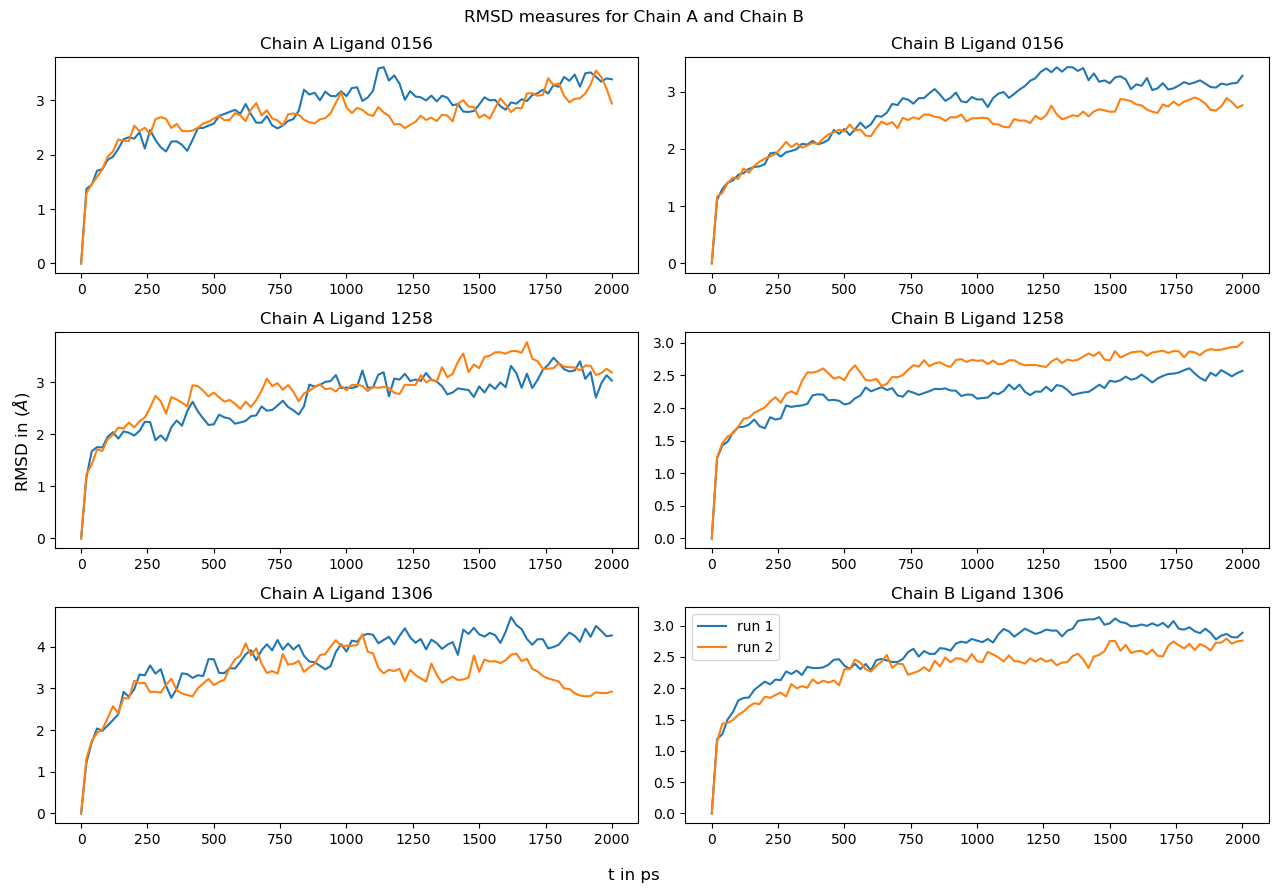

In [4]:
# Instantiate figure and axes depending on the number of ligands to plot (nrows)
fig, axs = plt.subplots(nrows=len(L_ids), ncols=2, figsize=(13,3*len(L_ids)))

# iterate over the simulated ligands
for i,L_id in enumerate(L_ids):
    # iterate the production runs
    for rep in reps:
        # create a universe, aka the simulated system with MDAnalysis
        u = mda.Universe(top.format(L_id,L_id),
                         trj.format(L_id,rep))
        
        # get the atoms of chainA and chain B and calculate their time resolved RMSD
        chainA = u.residues[A_resid-1].atoms
        chainB = u.residues[B_resid-1].atoms
        rmsdA = rms.RMSD(chainA, ref_frame=0).run().results.rmsd.T
        rmsdB = rms.RMSD(chainB, ref_frame=0).run().results.rmsd.T
        
        # plot the simulation time against the RMSD and specify label and title of each axis
        axs[i,0].plot(rmsdA[1],rmsdA[2], label='run '+str(rep))
        axs[i,1].plot(rmsdB[1],rmsdB[2], label='run '+str(rep))
        axs[i,0].set_title('Chain A Ligand '+L_id)
        axs[i,1].set_title('Chain B Ligand '+L_id)

# more figure specifications
fig.suptitle('RMSD measures for Chain A and Chain B')
fig.supxlabel('t in ps')
fig.supylabel('RMSD in ($\AA$)')
plt.legend()
plt.tight_layout()
plt.savefig('../_output/RMSD_vs_time.png', dpi=480)
plt.show()

# RMSD of Interface Residues

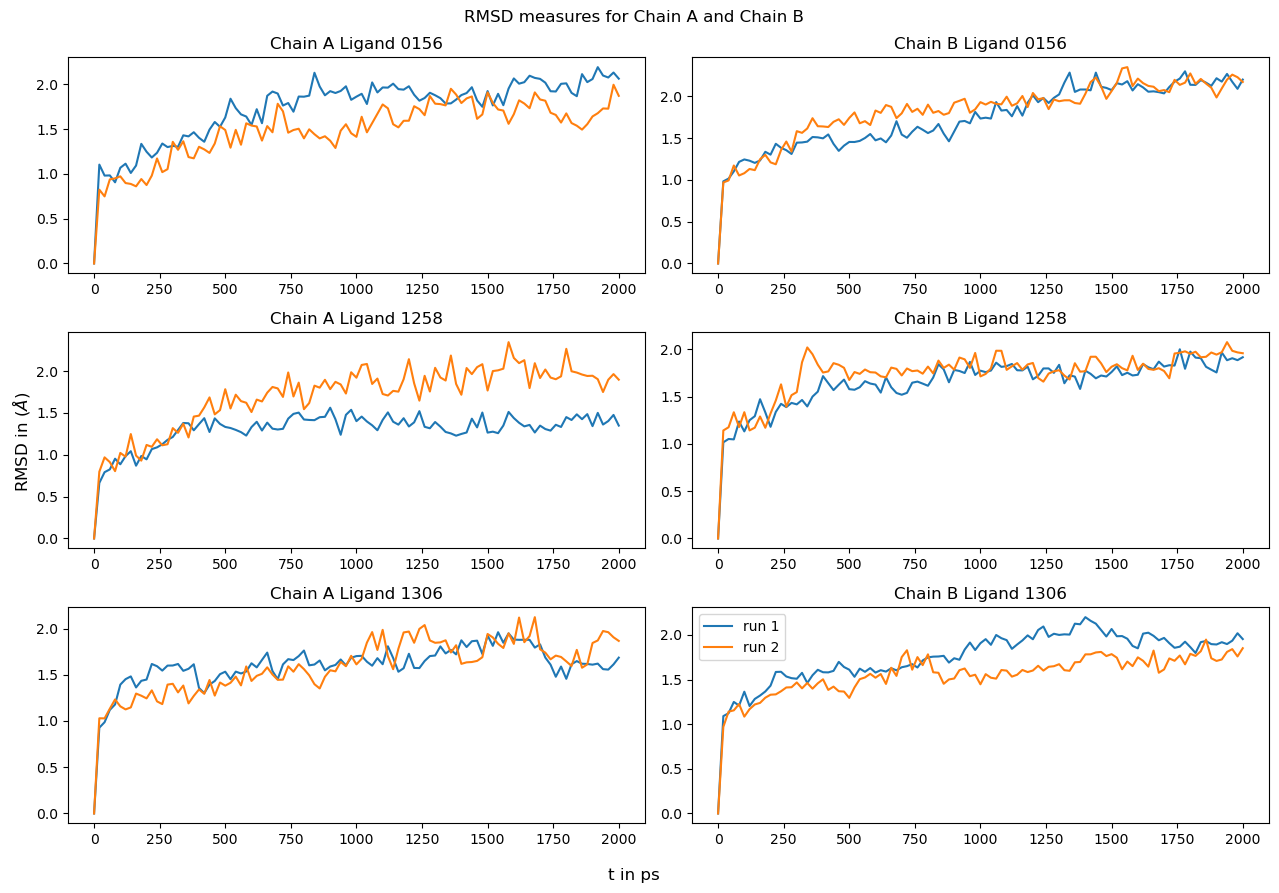

In [5]:
# Instantiate figure and axes depending on the number of ligands to plot (nrows)
fig, axs = plt.subplots(nrows=len(L_ids), ncols=2, figsize=(13,3*len(L_ids)))

# iterate over the simulated compounds
for i,L_id in enumerate(L_ids):
    # iterate over the different production simulations
    for rep in reps:
        
        # create a universe, aka the simulated system with MDAnalysis 
        u = mda.Universe(top.format(L_id,L_id),
                         trj.format(L_id,rep))
        
        # get the interfacial atoms of chainA and chain B and calculate their time resolved RMSD
        chainA = u.residues[A_ires-1].atoms
        chainB = u.residues[B_ires-1].atoms
        rmsdA = rms.RMSD(chainA, ref_frame=0).run().results.rmsd.T
        rmsdB = rms.RMSD(chainB, ref_frame=0).run().results.rmsd.T
        
        # plot the simulation time against the RMSD and specify label and title of each axis
        axs[i,0].plot(rmsdA[1],rmsdA[2], label='run '+str(rep))
        axs[i,1].plot(rmsdB[1],rmsdB[2], label='run '+str(rep))
        axs[i,0].set_title('Chain A Ligand '+L_id)
        axs[i,1].set_title('Chain B Ligand '+L_id)

# more figure specifications
fig.suptitle('RMSD measures for Chain A and Chain B')
fig.supxlabel('t in ps')
fig.supylabel('RMSD in ($\AA$)')
plt.legend()
plt.tight_layout()
plt.savefig('../_output/RMSD_vs_time_ires.png', dpi=480)
plt.show()

# RMSF Calculations (Atom-wise, Residue-wise, Interfacial)

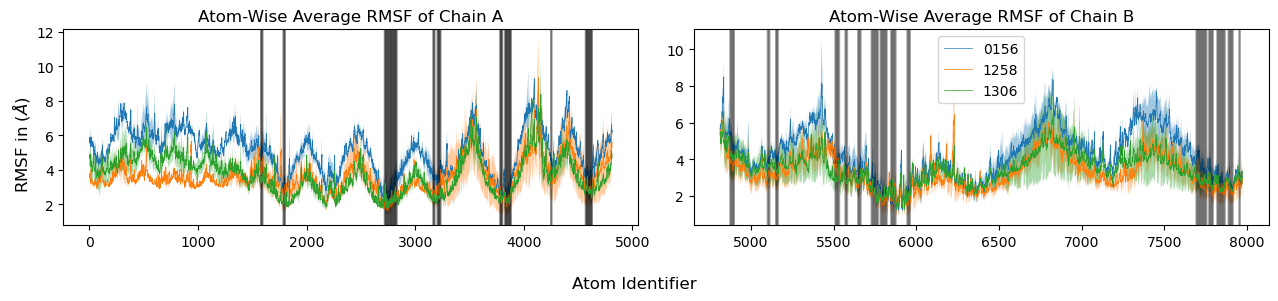

In [6]:
# instantiate figure object and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))

# iterate over the simulated ligand
for i,L_id in enumerate(L_ids):
    
    # instantiate lists to hold the rmsf results of each run for later averaging
    rmsfA = []
    rmsfB = []
    # iterate over the production runs
    for j,rep in enumerate(reps):
        
        # create a universe, aka the simulated system with MDAnalysis  
        u = mda.Universe(top.format(L_id,L_id),
                         trj.format(L_id,rep))
        
        # get the atoms of chainA and chain B and calculate their atomwise RMSF
        chainA = u.residues[A_resid-1].atoms
        chainB = u.residues[B_resid-1].atoms
        rmsfA.append(rms.RMSF(chainA).run().results.rmsf)
        rmsfB.append(rms.RMSF(chainB).run().results.rmsf)
    
    # transfer the lists to arrays with the same name after all runs are accounted for
    rmsfA = np.array(rmsfA)
    rmsfB = np.array(rmsfB)
    
    # calculate the averages and standard dev. of the RMSF over the time axis (0)
    avgA = np.mean(rmsfA,axis=0)
    avgB = np.mean(rmsfB,axis=0)
    stdA = np.std(rmsfA,axis=0)
    stdB = np.std(rmsfB,axis=0)
    
    # plot vertical black lines to visualise interface atoms
    for atomA in u.residues[A_ires-1].atoms.ids:
        axs[0].axvline(atomA, c='black', alpha=0.3, lw=0.1)
    for atomB in u.residues[B_ires-1].atoms.ids:
        axs[1].axvline(atomB, c='black', alpha=0.3, lw=0.1)
    
    # plot the standard deviation as filled in area and plot the RMSF itself
    axs[0].fill_between(x=chainA.atoms.ids, y1=avgA-stdA,y2=avgA+stdA, alpha=0.4)
    axs[1].fill_between(x=chainB.atoms.ids, y1=avgB-stdB,y2=avgB+stdB, alpha=0.4)
    axs[0].plot(chainA.atoms.ids,avgA, linewidth=0.5, label=L_id)
    axs[1].plot(chainB.atoms.ids,avgB, linewidth=0.5, label=L_id)
    
    # set titles for both plots
    axs[0].set_title('Atom-Wise Average RMSF of Chain A')
    axs[1].set_title('Atom-Wise Average RMSF of Chain B')

# more figure specifications
fig.supxlabel('Atom Identifier')
fig.supylabel('RMSF in ($\AA$)')
plt.legend()
plt.tight_layout()
plt.savefig('../_output/RMSF_vs_atoms.png', dpi=480)
plt.show()

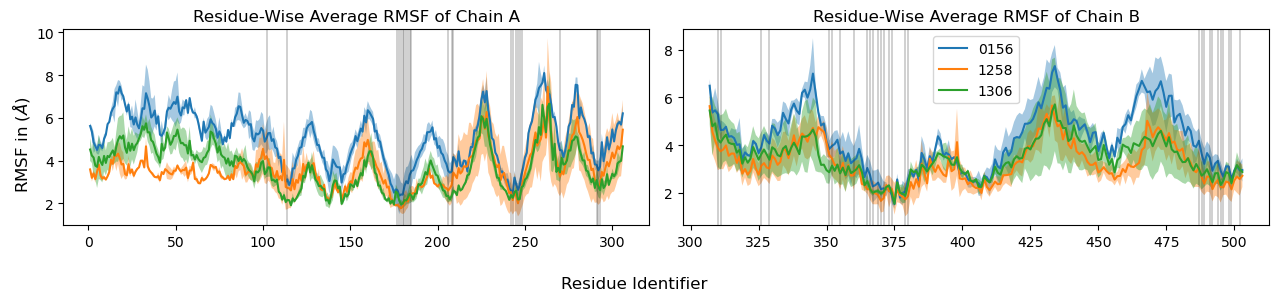

In [7]:
# instantiate figure object and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))
# iterate over the simulated ligand
for i,L_id in enumerate(L_ids):
    
    # instantiate lists to hold the rmsf residue wise results for each ligand
    rmsfA_res = []
    rmsfB_res = []
    # iterate over the production runs
    for rep in reps:
        
        # instantiate lists to hold the atom wise RMSF of each run 
        rmsfA = []
        rmsfB = []
        
        # create a universe, aka the simulated system with MDAnalysis  
        u = mda.Universe(top.format(L_id,L_id),
                         trj.format(L_id,rep))
        
        # get the atoms of chainA and chain B and calculate their residue wise RMSF
        chainA = u.residues[A_resid-1].atoms
        chainB = u.residues[B_resid-1].atoms
        for resA in u.residues[A_resid-1]:
            rmsfA.append(np.mean(rms.RMSF(resA.atoms).run().results.rmsf))
        for resB in u.residues[B_resid-1]:
            rmsfB.append(np.mean(rms.RMSF(resB.atoms).run().results.rmsf))
        
        # append the residue wise RMSF of each production run to these Lists
        rmsfA_res.append(rmsfA)
        rmsfB_res.append(rmsfB)
    
    # turn the residue wise RMSF of each production run into arrays and calculate averages and standard deviations
    rmsfA = np.array(rmsfA_res)
    rmsfB = np.array(rmsfB_res)
    avgA = np.mean(rmsfA,axis=0)
    avgB = np.mean(rmsfB,axis=0)
    stdA = np.std(rmsfA,axis=0)
    stdB = np.std(rmsfB,axis=0)
    
    # visualise the interfacial residues as black lines
    for iresA in A_ires:
        axs[0].axvline(iresA, c='black', alpha=0.3, lw=0.3)
    for iresB in B_ires:
        axs[1].axvline(iresB, c='black', alpha=0.3, lw=0.3)
    
    # plot the standard deviation as filled in area and plot the RMSF itself
    axs[0].fill_between(x=chainA.residues.resids, y1=avgA-stdA,y2=avgA+stdA, alpha=0.4)
    axs[1].fill_between(x=chainB.residues.resids, y1=avgB-stdB,y2=avgB+stdB, alpha=0.4)
    axs[0].plot(chainA.residues.resids, avgA, label=L_id)
    axs[1].plot(chainB.residues.resids, avgB, label=L_id)
    
    # set titles for both plots
    axs[0].set_title('Residue-Wise Average RMSF of Chain A')
    axs[1].set_title('Residue-Wise Average RMSF of Chain B')

# more figure specifications
fig.supxlabel('Residue Identifier')
fig.supylabel('RMSF in ($\AA$)')
plt.legend()
plt.tight_layout()
plt.savefig('../_output/RMSF_vs_resids.png', dpi=480)
plt.show()

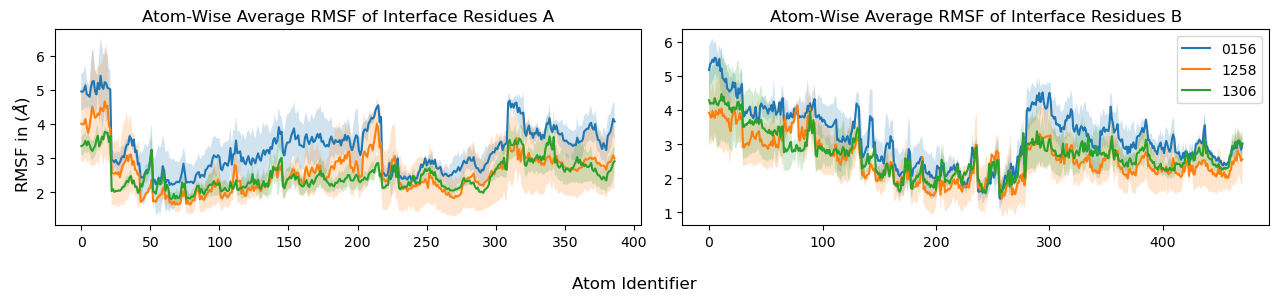

In [9]:
# instantiate figure object and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,3))
# iterate over the simulated ligands
for i,L_id in enumerate(L_ids):
    
    # instantiate lists for holding the atomwise RMSF of interfacial residues
    rmsfA = []
    rmsfB = []
    # iterate over the available production runs
    for j,rep in enumerate(reps):
        
        # create a universe, aka the simulated system with MDAnalysis  
        u = mda.Universe(top.format(L_id,L_id),
                         trj.format(L_id,rep))
        
        # get the interface atoms of chainA and chain B and calculate their RMSF
        chainA = u.residues[A_ires-1].atoms
        chainB = u.residues[B_ires-1].atoms
        rmsfA.append(rms.RMSF(chainA).run().results.rmsf)
        rmsfB.append(rms.RMSF(chainB).run().results.rmsf)
        
    # turn the residue wise RMSF of each production run into arrays and calculate averages and standard deviations
    rmsfA = np.array(rmsfA)
    rmsfB = np.array(rmsfB)
    avgA = np.mean(rmsfA,axis=0)
    avgB = np.mean(rmsfB,axis=0)
    stdA = np.std(rmsfA,axis=0)
    stdB = np.std(rmsfB,axis=0)
    
    # plot the standard deviation as filled in area and plot the RMSF itself 
    axs[0].fill_between(np.arange(avgA.shape[0]), avgA-stdA, avgA+stdA, alpha=0.2)
    axs[1].fill_between(np.arange(avgB.shape[0]), avgB-stdB, avgB+stdB, alpha=0.2)
    axs[0].plot(avgA, label=L_id)
    axs[1].plot(avgB, label=L_id)
    axs[0].set_title('Atom-Wise Average RMSF of Interface Residues A')
    axs[1].set_title('Atom-Wise Average RMSF of Interface Residues B')

# more figure specifications
fig.supxlabel('Atom Identifier')
fig.supylabel('RMSF in ($\AA$)')
plt.legend()
plt.tight_layout()
plt.savefig('../_output/RMSF_vs_iresids.png', dpi=480)
plt.show()